In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
random.seed(100)

In [2]:
def transmitting_links(network, p, flights, start_node):

    #Create dataframe storing airport and infection time 
    airports = sorted(network.nodes())
    inf_time = np.full((len(airports),), np.inf)
    inf_node = np.full((len(airports),), np.nan)
    infection = pd.DataFrame({"Airport":airports, "InfectionTime": inf_time, "InfectedNode": inf_node}) 
    
    #Set the infection time of first infected node:
    infection.InfectionTime[start_node] = flights.StartTime.min()
    #Loop over flights and start infection 
    for i in range(len(flights)):
        source = flights.Source[i]
        source_inf_time = infection.InfectionTime[source]
        if (source_inf_time < flights.StartTime[i]):
            random = np.random.rand()
            if random <= p:
                target = flights.Destination[i]
                target_cur_inf_time = infection.InfectionTime[target]
                target_new_inf_time = flights.EndTime[i]
                if target_new_inf_time < target_cur_inf_time:
                    infection.InfectionTime[target] = target_new_inf_time
                    infection.InfectedNode[target] = source
    return infection

In [3]:
flights = pd.read_csv("./events_US_air_traffic_GMT.txt", sep = " ")

#Read in network data
networkpath = "./aggregated_US_air_traffic_network_undir.edg"
network = nx.read_weighted_edgelist(networkpath, nodetype = int )


In [4]:
#Random start node
j = 0
start_list = []
for k in range(20):
    random = np.random.randint(len(network))
    start_list.append(random)
links = {}
for i in start_list:
    transmit_links = transmitting_links(network, 0.5, flights, i)
    for j in range(len(transmit_links)):
        if np.isnan(transmit_links.InfectedNode[j]) == False:
            u = transmit_links.Airport[j]
            v = int(transmit_links.InfectedNode[j])
            if u < v: 
                if (u,v) not in links.keys():
                    links[(u,v)] = 1/20
                else:
                    links[(u,v)] += 1/20
            else:
                if (v,u) not in links.keys():
                    links[(v,u)] = 1/20
                else:
                    links[(v,u)] += 1/20



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


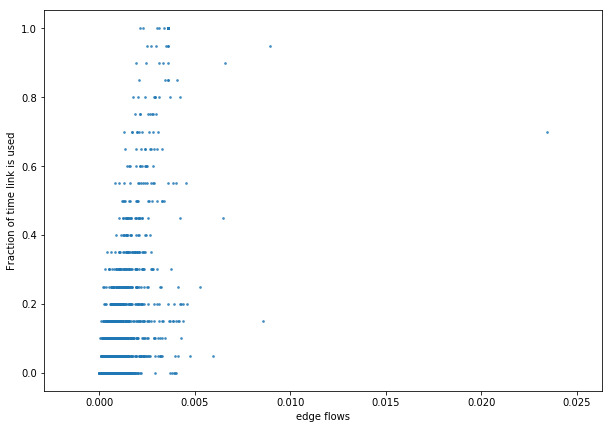

Spearman coef of edge_flows : SpearmanrResult(correlation=0.6749035134812968, pvalue=1.1558443529180774e-277)


In [16]:
from scipy import stats
edge_flow = nx.edge_current_flow_betweenness_centrality(network, normalized=True, weight='weight')
f_ij = []
edge_flows= []
for u,v in network.edges():
    if (u,v) in links.keys():
        f_ij.append(links[(u,v)])
    elif (v,u) in links.keys():
        f_ij.append(links[(v,u)])
    else:
        f_ij.append(0)
for u,v in network.edges():
    if (u,v) in edge_flow.keys():
        edge_flows.append(edge_flow[(u,v)])
    elif (v,u) in edge_flow.keys():
        edge_flows.append(edge_flow[(v,u)])
    else:
        edge_flows.append(0)
fig = plt.figure(figsize=(10,7))
plt.scatter(edge_flows, f_ij, s = 3, alpha = 0.7)
plt.xlabel("edge flows")
plt.ylabel("Fraction of time link is used")
plt.show()
spearman = stats.spearmanr(edge_flows, f_ij)
print("Spearman coef of edge_flows" + " :", spearman)

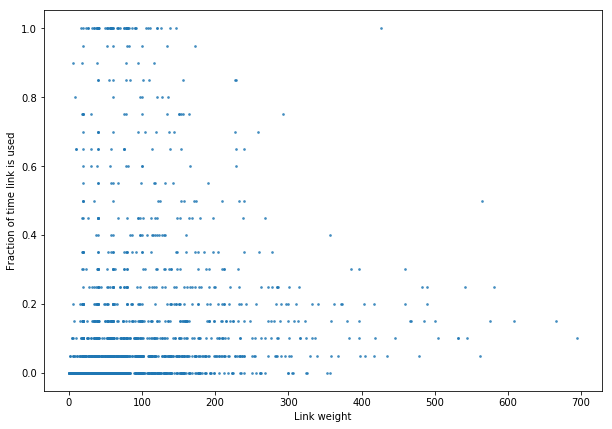

Spearman coef Link weight : SpearmanrResult(correlation=0.3361846094461893, pvalue=2.4440540118003243e-56)


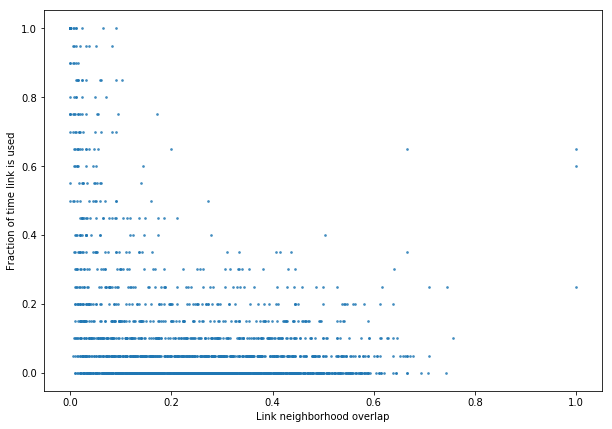

Spearman coef Link neighborhood overlap : SpearmanrResult(correlation=-0.3729324133895321, pvalue=6.859056792521477e-70)


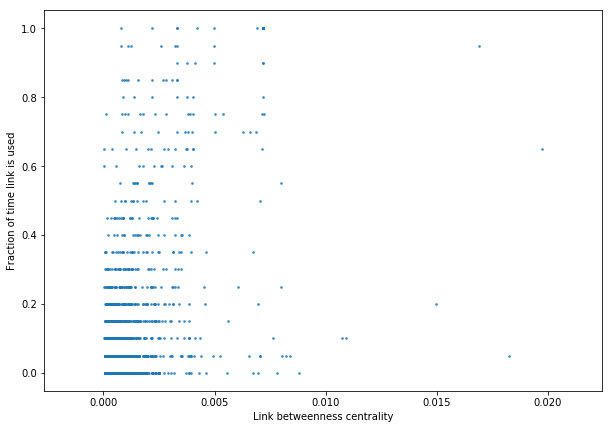

Spearman coef Link betweenness centrality : SpearmanrResult(correlation=0.4413538366105421, pvalue=2.871023785165934e-100)


In [125]:
linkweight = [w['weight'] for u,v,w in network.edges(data = True)]
link_betweenness = nx.edge_betweenness_centrality(network)
link_betweenness_centrality = []
f_ij = []
for u,v in network.edges():
    if (u,v) in links.keys():
        f_ij.append(links[(u,v)])
    elif (v,u) in links.keys():
        f_ij.append(links[(v,u)])
    else:
        f_ij.append(0)
    link_betweenness_centrality.append(link_betweenness[(u,v)])

y_values = [linkweight, neighborhood_overlap, link_betweenness_centrality]
y_labels = ["Link weight", "Link neighborhood overlap", "Link betweenness centrality"]

for y_val, label in zip(y_values, y_labels):
    fig = plt.figure(figsize=(10,7))
    plt.scatter(y_val, f_ij, s = 3, alpha = 0.7)
    plt.xlabel(label)
    plt.ylabel("Fraction of time link is used")
    plt.show()
    spearman = stats.spearmanr(y_val, f_ij)
    print("Spearman coef " + label + " :", spearman)
